In [1]:
import ee
ee.Initialize()
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 500)
from datetime import datetime, timedelta
import functools
import ast

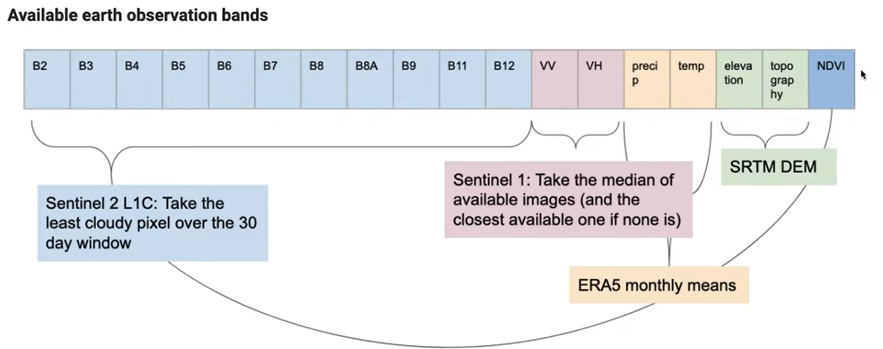

This is the order according to the CSV example in the repo:

VV, VH, B2, B3, B4, B5, B6, B7, B8, B8A, B9, B11, B12, temperature (kelvin), precipitation, elevation, topography, NDVI

In [2]:
def generate_intervals_by_number_of_intervals(start_date, end_date, num_intervals):
    """
    Function to generate time intervals according to predefined number of intervals
    Divide the date range between start_date and end_date into num_intervals equal intervals.

    Args:
        start_date (str): Start date in 'YYYY-MM-DD' format.
        end_date (str): End date in 'YYYY-MM-DD' format.
        num_intervals (int): Number of equal intervals to divide the range.

    Returns:
        list: List of (start, end) tuples for each interval.
    """
    # Convert strings to datetime objects
    start_date = datetime.strptime(start_date, "%Y-%m-%d")
    end_date = datetime.strptime(end_date, "%Y-%m-%d")
    
    # Calculate the total number of days and interval duration
    total_days = (end_date - start_date).days + 1  # Inclusive of both dates
    interval_duration = total_days // num_intervals
    remainder_days = total_days % num_intervals  # To distribute extra days

    intervals = []
    current_start = start_date

    for i in range(num_intervals):
        # Add one extra day to the interval if remainder_days are left
        extra_day = 1 if i < remainder_days else 0
        current_end = current_start + timedelta(days=interval_duration - 1 + extra_day)
        
        # Ensure the last interval ends exactly on end_date
        if i == num_intervals - 1:
            current_end = end_date
        
        intervals.append((current_start.strftime("%Y-%m-%d"), current_end.strftime("%Y-%m-%d")))
        current_start = current_end + timedelta(days=1)

    return intervals




def generate_intervals_by_number_of_days(start, end, step_days=30):
    '''
    Function to generate time intervals according to constant number of days
    '''
    
    start_date = datetime.strptime(start, "%Y-%m-%d")
    end_date = datetime.strptime(end, "%Y-%m-%d")
    intervals = []
    while start_date < end_date:
        interval_start = start_date
        interval_end = start_date + timedelta(days=step_days)
        intervals.append((interval_start.strftime("%Y-%m-%d"), interval_end.strftime("%Y-%m-%d")))
        start_date = interval_end
    return intervals

In [3]:
data = pd.read_csv(r"G:\My Drive\PRESTO\CSV_for_PRESTO_soy_not_soy.csv",parse_dates=['start_date','end_date'])
data = data.iloc[np.random.choice(data.index.tolist(),100)].copy()
data['unique_id'] = np.arange(0,len(data),1)

print(data.shape)
data.head()

(100, 8)


,lat,lon,value,value_binary,start_date,end_date,subset,unique_id
3989,35.563270,-76.857649,not_soy,0,2024-05-01,2024-09-29,testing,0
3832,35.563724,-76.857021,not_soy,0,2024-05-01,2024-09-29,testing,1
6683,35.699810,-76.764890,not_soy,0,2024-05-02,2024-09-26,training,2
2058,35.511062,-76.830723,soy,1,2023-06-03,2023-11-07,training,3
69,35.618760,-76.861850,soy,1,2023-06-14,2023-11-08,validation,4


In [4]:
# Predefined start and end dates
start_date = '2023-05-01'
end_date = '2024-09-29'
num_intervals = 24

# Get time intervals
time_intervals = generate_intervals_by_number_of_intervals(start_date, end_date, num_intervals)

# get elevation and topography


In [5]:
points = [ee.Geometry.Point([x,y]) for x,y in zip(data['lon'],data['lat'])]

# Load the elevation image
elevation = ee.Image("USGS/SRTMGL1_003").select('elevation')

# Calculate the slope
slope = ee.Terrain.slope(elevation)

# Combine elevation and slope into a single image
combined = elevation.addBands(slope).rename(['elevation', 'slope'])

# Function to extract elevation and slope for a single point
def get_values_for_point(point):
    values = combined.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=point,
        scale=30
    )
    return {
        'elevation': values.get('elevation'),
        'slope': values.get('slope')
    }

# Process all points and accumulate results
results = [get_values_for_point(point) for point in points]

# Fetch the results as a list of dictionaries with getInfo()
final_results = [
    {
        'elevation': result['elevation'].getInfo(),
        'slope': result['slope'].getInfo()
    } for result in results
]

elevation_slope = pd.DataFrame(final_results)
elevation_slope.rename(columns={'slope':'topography'},inplace=True)
elevation_slope['unique_id'] = data['unique_id'].tolist()
print(elevation_slope.shape)
elevation_slope.head()

(100, 3)


,elevation,topography,unique_id
0,9,0.927410,0
1,10,2.460232,1
2,13,5.765831,2
3,5,1.468867,3
4,14,2.461681,4


# get sentinel-1

In [6]:
# Function to calculate median VV and VH for a given point and time period
def get_median_vv_vh(lat, lon, time_period):
    point = ee.Geometry.Point([lon, lat])
    
    s1 = ee.ImageCollection('COPERNICUS/S1_GRD') \
        .filterBounds(point) \
        .filterDate(time_period[0], time_period[1]) \
        .filter(ee.Filter.eq('instrumentMode', 'IW')) \
        .filter(ee.Filter.eq('resolution', 'H')) \
        .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
        .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH'))

   # Reduce the ImageCollection to a single median composite
    median_image = s1.median()
    
    # Calculate median VV and VH at the point
    medians = median_image.reduceRegion(
        reducer=ee.Reducer.mean(),  # Replace with Reducer.median() for non-mean
        geometry=point,
        scale=10
    )
    
    return medians.get('VV'), medians.get('VH')


# Process each point and time interval
results = []
for _, row in data.iterrows():
    lat, lon, unique_id = row['lat'], row['lon'],row['unique_id']    
    for time_period in time_intervals:
        median_vv, median_vh = get_median_vv_vh(lat, lon, time_period)
        results.append({
            'unique_id': unique_id,
            'lat': lat,
            'lon': lon,
            'time_period': f"{time_period[0]} to {time_period[1]}",
            'VV': median_vv.getInfo() if median_vv else None,
            'VH': median_vh.getInfo() if median_vh else None
        })

sn1 = pd.DataFrame(results)
print(sn1.shape)
sn1.head()

(2400, 6)


,unique_id,lat,lon,time_period,VV,VH
0,0,35.56327,-76.857649,2023-05-01 to 2023-05-22,-11.675913,-18.826757
1,0,35.56327,-76.857649,2023-05-23 to 2023-06-13,-11.160397,-16.730215
2,0,35.56327,-76.857649,2023-06-14 to 2023-07-05,-9.867735,-17.127437
3,0,35.56327,-76.857649,2023-07-06 to 2023-07-27,-8.797277,-15.604364
4,0,35.56327,-76.857649,2023-07-28 to 2023-08-18,-8.341874,-14.480790


# get sentinel-2

In [7]:
# Define the bands to extract
bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12']

# Function to calculate median for a given time period
def calculate_median_for_point(lat, lon, time_period):
    point = ee.Geometry.Point(lon, lat)
    
    # Load Sentinel-2 image collection
    s2 = ee.ImageCollection('COPERNICUS/S2_SR') \
        .filterBounds(point) \
        .filterDate(time_period[0], time_period[1]) \
#         .filter(ee.Filter.eq('SCL', [2, 4, 5]))  # Keep only pixels with SCL = 2, 4, 5
    
    # Add NDVI calculation
    s2 = s2.map(lambda img: img.addBands(
        img.normalizedDifference(['B8','B4']).rename('NDVI')
    ))
    
    # Reduce to median
    median = s2.select(bands + ['NDVI']).median().reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=point,
        scale=10
    )
    
    return median.getInfo()

# Prepare an empty list to hold results
results = []

# Loop through each point in the DataFrame
for _, row in data.iterrows():
    lat, lon, unique_id = row['lat'], row['lon'], row['unique_id']
    for time_period in time_intervals:
        try:
            median_values = calculate_median_for_point(lat, lon, time_period)
            median_values.update({
                'lat': lat,
                'lon': lon,
                'time_period': f"{time_period[0]} to {time_period[1]}",
                'unique_id': unique_id
            })
            results.append(median_values)
        except Exception as e:
            print(f"Error for point {unique_id}, period {time_period}: {e}")


sn2 = pd.DataFrame(results)
sn2 = sn2[['unique_id', 'lat', 'lon', 'time_period'] + bands + ['NDVI']]
print(sn2.shape)
sn2.head()

(2400, 16)


,unique_id,lat,lon,time_period,B2,B3,B4,B5,B6,B7,B8,B8A,B9,B11,B12,NDVI
0,0,35.56327,-76.857649,2023-05-01 to 2023-05-22,2395.0,2537.0,2528.0,3037.5,3994.5,4269.5,4536,4518.5,4948.5,4292.5,3246.0,0.279944
1,0,35.56327,-76.857649,2023-05-23 to 2023-06-13,4129.0,4003.0,3919.0,4358.0,4888.0,5121.0,5130,5265.0,6789.0,4427.0,3790.0,0.141024
2,0,35.56327,-76.857649,2023-06-14 to 2023-07-05,1626.0,1936.0,1719.0,2351.0,3827.0,4293.0,4908,4409.0,4293.0,3905.0,2649.0,0.453505
3,0,35.56327,-76.857649,2023-07-06 to 2023-07-27,3514.0,3460.0,3050.0,3608.0,4713.0,5259.0,5476,5176.0,6196.0,3557.0,2907.0,0.252468
4,0,35.56327,-76.857649,2023-07-28 to 2023-08-18,1421.0,1664.0,1446.5,1932.5,4301.0,5453.0,5320,5772.0,6380.5,3297.0,2102.5,0.512226


# get ERA5

In [8]:
def calculate_era5_statistics(lat, lon, time_period):
    point = ee.Geometry.Point(lon, lat)
    
    # Load the ECMWF ERA5 Land Daily Aggregates dataset
    era5 = ee.ImageCollection('ECMWF/ERA5_LAND/DAILY_AGGR') \
        .filterBounds(point) \
        .filterDate(time_period[0], time_period[1]) \
        .select(['temperature_2m', 'total_precipitation_sum'])
    
    # Reduce the collection to a single image (mean for temperature, sum for precipitation)
    reduced_image = era5.reduce(
        reducer=ee.Reducer.mean().combine(
            reducer2=ee.Reducer.sum(),
            sharedInputs=True
        )
    )
    
    # Extract mean temperature and sum precipitation at the point
    reduced_values = reduced_image.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=point,
        scale=1000,  # ERA5 has ~9km resolution
        maxPixels=1e9
    )
    
    # Extract and return the stats
    stats = reduced_values.getInfo()
    return {
        'temp': stats.get('temperature_2m_mean', None),  # Mean temperature
        'precip': stats.get('total_precipitation_sum_sum', None)  # Sum precipitation
    }


# Prepare an empty list to hold results
results = []

# Loop through each point in the DataFrame
for _, row in data.iterrows():
    lat, lon, unique_id = row['lat'], row['lon'], row['unique_id']
    for time_period in time_intervals:
        try:
            stats = calculate_era5_statistics(lat, lon, time_period)
            stats.update({
                'lat': lat,
                'lon': lon,
                'unique_id': unique_id,
                'time_period': f"{time_period[0]} to {time_period[1]}",
            })
            results.append(stats)
        except Exception as e:
            print(f"Error for point {unique_id}: {e}")

ERA5 = pd.DataFrame(results)
print(ERA5.shape)
ERA5.head()

(2400, 6)


,temp,precip,lat,lon,unique_id,time_period
0,292.116201,0.049084,35.56327,-76.857649,0,2023-05-01 to 2023-05-22
1,293.016546,0.059036,35.56327,-76.857649,0,2023-05-23 to 2023-06-13
2,298.061432,0.087709,35.56327,-76.857649,0,2023-06-14 to 2023-07-05
3,299.894536,0.108490,35.56327,-76.857649,0,2023-07-06 to 2023-07-27
4,299.967417,0.072792,35.56327,-76.857649,0,2023-07-28 to 2023-08-18


In [10]:
optical_weather = functools.reduce(lambda left, right: pd.merge(left,right,on=['unique_id','time_period','lat','lon']), [sn2,sn1,ERA5])
optical_weather_topo = pd.merge(optical_weather,elevation_slope,on='unique_id')
print(optical_weather_topo.shape)
optical_weather_topo.head()

(2400, 22)


,unique_id,lat,lon,time_period,B2,B3,B4,B5,B6,B7,B8,B8A,B9,B11,B12,NDVI,VV,VH,temp,precip,elevation,topography
0,0,35.56327,-76.857649,2023-05-01 to 2023-05-22,2395.0,2537.0,2528.0,3037.5,3994.5,4269.5,4536,4518.5,4948.5,4292.5,3246.0,0.279944,-11.675913,-18.826757,292.116201,0.049084,9,0.92741
1,0,35.56327,-76.857649,2023-05-23 to 2023-06-13,4129.0,4003.0,3919.0,4358.0,4888.0,5121.0,5130,5265.0,6789.0,4427.0,3790.0,0.141024,-11.160397,-16.730215,293.016546,0.059036,9,0.92741
2,0,35.56327,-76.857649,2023-06-14 to 2023-07-05,1626.0,1936.0,1719.0,2351.0,3827.0,4293.0,4908,4409.0,4293.0,3905.0,2649.0,0.453505,-9.867735,-17.127437,298.061432,0.087709,9,0.92741
3,0,35.56327,-76.857649,2023-07-06 to 2023-07-27,3514.0,3460.0,3050.0,3608.0,4713.0,5259.0,5476,5176.0,6196.0,3557.0,2907.0,0.252468,-8.797277,-15.604364,299.894536,0.108490,9,0.92741
4,0,35.56327,-76.857649,2023-07-28 to 2023-08-18,1421.0,1664.0,1446.5,1932.5,4301.0,5453.0,5320,5772.0,6380.5,3297.0,2102.5,0.512226,-8.341874,-14.480790,299.967417,0.072792,9,0.92741


In [11]:
df_points = []

for i,gpby in optical_weather_topo.groupby(['unique_id','lat','lon']):
    a=5
    df_point = pd.DataFrame(i).T
    df_point.columns = ['unique_id','lat','lon']
    df_point['eo_data'] = 'aa'
    df_point.at[0,'eo_data'] = gpby[['VV','VH','B2','B3','B4','B5','B6','B7','B8','B8A','B9','B11','B12','temp','precip','elevation','topography','NDVI']].values.tolist()
    df_points.append(df_point)
    
eo_date = pd.concat(df_points)
print(eo_date.shape)
eo_date.head()

(100, 4)


,unique_id,lat,lon,eo_data
0,0.0,35.563270,-76.857649,"[[-11.675913431536781, -18.826757087400843, 23..."
0,1.0,35.563724,-76.857021,"[[-8.606636533074038, -22.58628494739659, 2515..."
0,2.0,35.699810,-76.764890,"[[-14.351114510232906, -25.847286754702793, 30..."
0,3.0,35.511062,-76.830723,"[[-10.161354773969219, -23.6909982315009, 2326..."
0,4.0,35.618760,-76.861850,"[[-13.066747240173182, -15.96556768516871, 424..."


# add metadata

In [12]:
meta = pd.read_csv(r"G:\My Drive\PRESTO\CSV_for_PRESTO_soy_not_soy.csv")
meta

,lat,lon,value,value_binary,start_date,end_date,subset
0,35.618940,-76.862837,soy,1,2023-06-14,2023-11-08,training
1,35.618940,-76.862747,soy,1,2023-06-14,2023-11-08,validation
2,35.618940,-76.862657,soy,1,2023-06-14,2023-11-08,testing
3,35.618940,-76.862567,soy,1,2023-06-14,2023-11-08,training
4,35.618940,-76.862478,soy,1,2023-06-14,2023-11-08,training
...,...,...,...,...,...,...,...
10983,35.693239,-76.760379,not_soy,0,2024-05-02,2024-09-26,training
10984,35.693239,-76.760289,not_soy,0,2024-05-02,2024-09-26,training
10985,35.693149,-76.760469,not_soy,0,2024-05-02,2024-09-26,training
10986,35.693149,-76.760379,not_soy,0,2024-05-02,2024-09-26,training


In [13]:
dataset_for_presto = pd.merge(meta,eo_date,on=['lat','lon'])
dataset_for_presto.drop('unique_id',inplace=True,axis=1)
print(dataset_for_presto.shape)
dataset_for_presto.head()

(100, 8)


,lat,lon,value,value_binary,start_date,end_date,subset,eo_data
0,35.618850,-76.861760,soy,1,2023-06-14,2023-11-08,training,"[[-11.852917431961279, -15.381737017701496, 45..."
1,35.618760,-76.861850,soy,1,2023-06-14,2023-11-08,validation,"[[-13.066747240173182, -15.96556768516871, 424..."
2,35.618488,-76.862657,soy,1,2023-06-14,2023-11-08,training,"[[-15.015968247888557, -20.834678055482556, 40..."
3,35.618127,-76.861850,soy,1,2023-06-14,2023-11-08,training,"[[-12.465941614253527, -18.67568397381072, 485..."
4,35.617494,-76.860953,soy,1,2023-06-14,2023-11-08,training,"[[-14.217268511883347, -21.427731364837637, 65..."


# prepare dataset for PRESTO

In [2]:
# dataset_for_presto.to_csv(r'G:\My Drive\PRESTO\soy_not_soy_eo_data_label_for_presto.csv')
dataset_for_presto = pd.read_csv(r'G:\My Drive\PRESTO\soy_not_soy_eo_data_label_for_presto.csv')
print(dataset_for_presto.shape)
dataset_for_presto.head()

(100, 9)


,Unnamed: 0,lat,lon,value,value_binary,start_date,end_date,subset,eo_data
0,0,35.618850,-76.861760,soy,1,2023-06-14,2023-11-08,training,"[[-11.852917431961279, -15.381737017701496, 45..."
1,1,35.618760,-76.861850,soy,1,2023-06-14,2023-11-08,validation,"[[-13.066747240173182, -15.96556768516871, 424..."
2,2,35.618488,-76.862657,soy,1,2023-06-14,2023-11-08,training,"[[-15.015968247888557, -20.834678055482556, 40..."
3,3,35.618127,-76.861850,soy,1,2023-06-14,2023-11-08,training,"[[-12.465941614253527, -18.67568397381072, 485..."
4,4,35.617494,-76.860953,soy,1,2023-06-14,2023-11-08,training,"[[-14.217268511883347, -21.427731364837637, 65..."


In [3]:
X_array = np.array(dataset_for_presto["eo_data"].apply(ast.literal_eval).tolist())
X_array.shape

(100, 24, 18)

In [4]:
y_array = dataset_for_presto['value_binary'].values
y_array.shape

(100,)

In [5]:
Xy_as_tuple = (X_array,y_array)
Xy_as_tuple

(array([[[-1.18529174e+01, -1.53817370e+01,  4.56100000e+03, ...,
           1.40000000e+01,  2.46168060e+00,  1.30935967e-01],
         [-9.92597300e+00, -1.58538608e+01,  1.78050000e+03, ...,
           1.40000000e+01,  2.46168060e+00,  2.04721481e-01],
         [-1.12775247e+01, -1.35234249e+01,  1.81700000e+03, ...,
           1.40000000e+01,  2.46168060e+00,  2.40805000e-01],
         ...,
         [-8.03511269e+00, -1.41458876e+01,  6.76200000e+03, ...,
           1.40000000e+01,  2.46168060e+00,  1.12266712e-01],
         [-8.27060054e+00, -1.58353271e+01,  4.45950000e+03, ...,
           1.40000000e+01,  2.46168060e+00,  2.15562403e-01],
         [-9.41887851e+00, -1.50809002e+01,  4.23650000e+03, ...,
           1.40000000e+01,  2.46168060e+00,  2.33200878e-01]],
 
        [[-1.30667472e+01, -1.59655677e+01,  4.24500000e+03, ...,
           1.40000000e+01,  2.46168060e+00,  8.36417526e-02],
         [-1.14070139e+01, -2.07069247e+01,  1.87200000e+03, ...,
           1.40000000